In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools
import numpy as np
import gudhi as gh
import networkx as nx

from src.depth import DepthPoset
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import imageio

from tqdm import tqdm

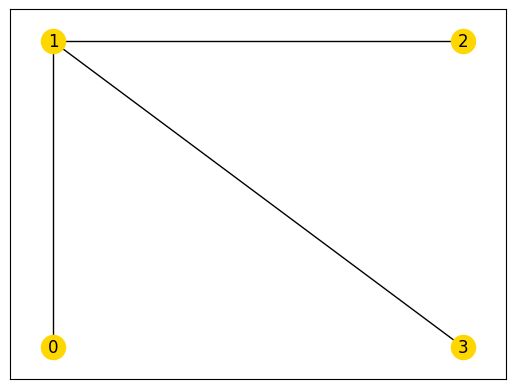

In [3]:
g = nx.Graph()
g.add_nodes_from([0, 1, 2, 3])
g.add_edges_from([(0, 1), (1, 2), (1, 3)])
g_pos = {0: np.array([-1., -1.]),
         1: np.array([-1.,  1.]), 
         2: np.array([ 1.,  1.]), 
         3: np.array([ 1., -1.])
}
g_pos.update({(key, ): g_pos[key] for key in g_pos.keys()})
g_pos.update({(key0, key1): 0.5*(g_pos[key0] + g_pos[key1]) for key0, key1 in itertools.product(g_pos.keys(), repeat=2)})
    
nx.draw_networkx(g, node_color='gold', pos=g_pos)

In [4]:
def draw_segment_area_border(p0, p1, r=1, n=120):
    # 
    p0, p1 = np.array([p0, p1])
    vector = p1 - p0
    normal = np.array([vector[1], -vector[0]])
    normal = normal/np.linalg.norm(normal)

    x0, y0 = np.array([p0 + r*normal, p1 + r*normal]).transpose()
    x2, y2 = np.array([p0 - r*normal, p1 - r*normal]).transpose()

    x1, y1 = np.array([p1 + r*normal@np.array([[ np.cos(alpha), np.sin(alpha)], 
                                               [-np.sin(alpha), np.cos(alpha)]]) for alpha in np.pi*np.arange(1, n)/n]).transpose()
    
    x3, y3 = np.array([p0 - r*normal@np.array([[ np.cos(alpha), np.sin(alpha)], 
                                               [-np.sin(alpha), np.cos(alpha)]]) for alpha in (np.pi*np.arange(1, n)/n)]).transpose()

    x = np.concatenate([x0, x1, np.flip(x2), x3, ])
    y = np.concatenate([y0, y1, np.flip(y2), y3, ])
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    return x, y

In [5]:
def polygon_intersection(x_list, y_list):
    """
    Computes the intersection of multiple polygons.
    
    Parameters:
    - x_list: List of arrays, each containing x-coordinates of a polygon's vertices.
    - y_list: List of arrays, each containing y-coordinates of a polygon's vertices.
    
    Returns:
    - (x, y): Coordinates of the intersected polygon as two arrays.
    - None: If there is no intersection.
    """
    # Convert x, y coordinates to Shapely polygons
    polygons = [Polygon(zip(x, y)) for x, y in zip(x_list, y_list)]
    
    # Compute the intersection of all polygons
    intersection = polygons[0]
    for poly in polygons[1:]:
        intersection = intersection.intersection(poly)
        if intersection.is_empty:
            return None  # No intersection exists

    # Convert the intersection polygon back to x, y coordinates
    if intersection.is_empty:
        return None
    else:
        x, y = intersection.exterior.coords.xy
        return np.array(x), np.array(y)


In [6]:
def polygon_union(x_list, y_list):
    """
    Computes the union of two polygons (Polygon 1 ∪ Polygon 2).
    
    Parameters:
    - x_list: List of arrays, each containing x-coordinates of a polygon's vertices.
    - y_list: List of arrays, each containing y-coordinates of a polygon's vertices.
    
    Returns:
    - (x, y): Coordinates of the resulting union polygon.
    - None: If the union results in an empty geometry.
    """
    # Convert x, y coordinates to Shapely polygons
    polygon1 = Polygon(zip(x_list[0], y_list[0]))
    polygon2 = Polygon(zip(x_list[1], y_list[1]))
    
    # Compute the union (polygon1 ∪ polygon2)
    union = polygon1.union(polygon2)
    
    # Check if the union is empty
    if union.is_empty:
        return None
    
    # Convert the resulting union polygon back to x, y coordinates
    x, y = union.exterior.coords.xy
    return np.array(x), np.array(y)


  0%|                                                    | 0/29 [00:00<?, ?it/s]

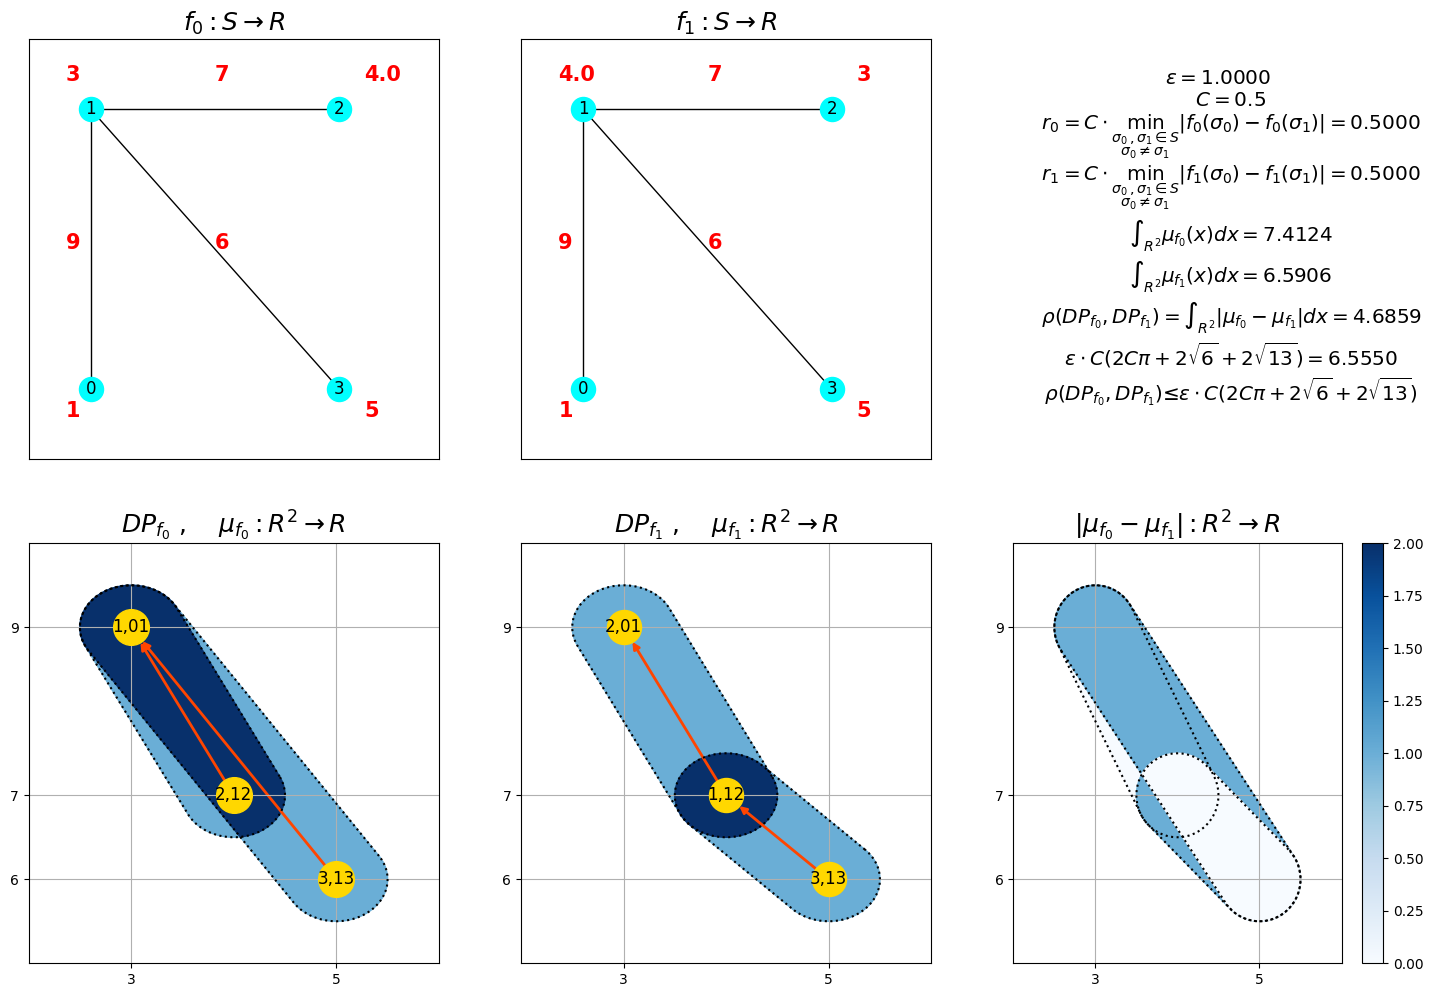

100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


In [7]:
epss = np.concatenate([np.arange(1, 0.05, -0.05), np.arange(0.05, 0, -0.005)])

path_template = 'pics/mc-{0}.png'
img_files = []

for ieps, eps in tqdm(enumerate(epss), total=len(epss)):
        
    r_coeff = 0.5
    r = r_coeff*eps
    
    filtration0 = {(0, ): 1, (1, ): 3, (2, ): 3 + eps, (3, ): 5, (0, 1): 9, (1, 2): 7, (1, 3): 6}
    filtration1 = {(0, ): 1, (1, ): 3 + eps, (2, ): 3, (3, ): 5, (0, 1): 9, (1, 2): 7, (1, 3): 6}
    for key in filtration0:
        filtration0[key] = round(filtration0[key], 6)
    for key in filtration1:
        filtration1[key] = round(filtration1[key], 6)
    
    stree0 = gh.SimplexTree()
    for simplex, filtration_value in filtration0.items():
        stree0.insert(simplex, filtration_value)
        
    stree1 = gh.SimplexTree()
    for simplex, filtration_value in filtration1.items():
        stree1.insert(simplex, filtration_value)
    
    dp0 = DepthPoset.from_simplex_tree(stree0)
    dp1 = DepthPoset.from_simplex_tree(stree1)
    
    
    fig, axs = plt.subplots(2, 3)
    fig.set_figwidth(18)
    fig.set_figheight(12)
    
    nx.draw_networkx(g, node_color='cyan', pos=g_pos, ax=axs[0, 0])
    for key in filtration0.keys():
        x, y = g_pos[key]*1.2
        axs[0, 0].text(x, y, f'{filtration0[key]}', color='red', weight='bold', size=15)
    axs[0, 0].set_xlim(-1.5, 1.8)
    axs[0, 0].set_ylim(-1.5, 1.5)
    
    nx.draw_networkx(g, node_color='cyan', pos=g_pos, ax=axs[0, 1])
    for key in filtration0.keys():
        x, y = g_pos[key]*1.2
        axs[0, 1].text(x, y, f'{filtration1[key]}', color='red', weight='bold', size=15)
    axs[0, 1].set_xlim(-1.5, 1.8)
    axs[0, 1].set_ylim(-1.5, 1.5)
    
    axs[0, 2].set_xticks([])
    axs[0, 2].set_yticks([])
    
    
    cmap = plt.get_cmap('Blues')
    norm = Normalize(vmin=0, vmax=2)
    
    
    labels0 = {node: f'{node.source[0][0]},{node.source[1][0]}{node.source[1][1]}' for node in dp0.nodes}
    graph0 = dp0.get_transitive_reduction()
    pos0 = dp0.persistant_layout()
    nx.draw_networkx(graph0, pos=pos0, ax=axs[1, 0], labels=labels0, 
                     hide_ticks=False, node_color='gold', node_size=660, width=2, edge_color='orangered')
    polygons_x = []
    polygons_y = []
    for n0, n1 in graph0.edges:
        p0 = pos0[n0]
        p1 = pos0[n1]
        x, y = draw_segment_area_border(p0, p1, r=r)
        polygons_x.append(x)
        polygons_y.append(y)
        axs[1, 0].plot(x, y, color='black', linestyle=':')
    
    x, y = polygon_union(polygons_x, polygons_y)
    axs[1, 0].fill(x, y, color=cmap(norm(1)), zorder=0)
    x, y = polygon_intersection(polygons_x, polygons_y)
    axs[1, 0].fill(x, y, color=cmap(norm(2)), zorder=0)
    
    
    labels1 = {node: f'{node.source[0][0]},{node.source[1][0]}{node.source[1][1]}' for node in dp1.nodes}
    graph1 = dp1.get_transitive_reduction()
    pos1 = dp1.persistant_layout()
    nx.draw_networkx(graph1, pos=pos1, ax=axs[1, 1], labels=labels1, 
                     hide_ticks=False, node_color='gold', node_size=600, width=2, edge_color='orangered')
    polygons_x = []
    polygons_y = []
    for n0, n1 in graph1.edges:
        p0 = pos1[n0]
        p1 = pos1[n1]
        x, y = draw_segment_area_border(p0, p1, r=r)
        polygons_x.append(x)
        polygons_y.append(y)
        axs[1, 1].plot(x, y, color='black', linestyle=':')
    
    x, y = polygon_union(polygons_x, polygons_y)
    axs[1, 1].fill(x, y, color=cmap(norm(1)), zorder=0)
    x, y = polygon_intersection(polygons_x, polygons_y)
    axs[1, 1].fill(x, y, color=cmap(norm(2)), zorder=0)
    
    
    polygons_x = []
    polygons_y = []
    for p0, p1 in itertools.combinations([(3, 9), (5, 6), (3 + eps, 7)], 2):
        x, y = draw_segment_area_border(p0, p1, r=r)
        polygons_x.append(x)
        polygons_y.append(y)
        axs[1, 2].plot(x, y, color='black', linestyle=':')
        axs[1, 2].fill(x, y, color=cmap(norm(0)), zorder=0)
    x, y = polygon_union([polygons_x[0], polygons_x[2]], 
                         [polygons_y[0], polygons_y[2]])
    axs[1, 2].fill(x, y, color=cmap(norm(1)), zorder=0)
    x, y = polygon_intersection([polygons_x[0], polygons_x[2]],
                                [polygons_y[0], polygons_y[2]])
    axs[1, 2].fill(x, y, color=cmap(norm(0)), zorder=0)
    
    polygon = Polygon(zip(x, y))
    
    
    l0 = (2**2 + eps**2)**0.5
    l1 = ((2 - eps)**2 + 1**2)**0.5
    l2 = (2**2 + 3**2)**0.5
    s0 = 2*r*l0 + np.pi*r**2
    s1 = 2*r*l1 + np.pi*r**2
    s2 = 2*r*l2 + np.pi*r**2
    s3 = s1 + s2 - polygon.area
    
    c_value = eps*r_coeff*(2*r_coeff + 2*(6**0.5 + 13**0.5))
    c_value_str = r'\varepsilon\cdot C(2C\pi + 2\sqrt{6} + 2\sqrt{13})'
    
    description = f'''$\\varepsilon = {eps:.4f}$
    $C = {r_coeff}$
    $r_0 = C\\cdot\\min_{{\\substack{{\\sigma_0, \\sigma_1 \\in S \\\\ \\sigma_0 \\ne \\sigma_1}}}} |f_0(\\sigma_0) - f_0(\\sigma_1)| = {r:.4f}$
    $r_1 = C\\cdot\\min_{{\\substack{{\\sigma_0, \\sigma_1 \\in S \\\\ \\sigma_0 \\ne \\sigma_1}}}} |f_1(\\sigma_0) - f_1(\\sigma_1)| = {r:.4f}$
    $\\int_{{R^2}} \\mu_{{f_0}}(x) dx = {s0 + s2:.4f}$
    $\\int_{{R^2}} \\mu_{{f_1}}(x) dx = {s1 + s2:.4f}$
    $\\rho(DP_{{f_0}}, DP_{{f_1}}) = \\int_{{R^2}} |\\mu_{{f_0}} - \\mu_{{f_1}}| dx = {s3:.4f}$
    ${c_value_str} = {c_value:.4f}$
    $\\rho(DP_{{f_0}}, DP_{{f_1}}) {'≤' if c_value >= s3 else '>'} {c_value_str}$
    '''
    axs[0, 2].text(0.5, 0.5, description, fontsize='x-large', va='center', ha='center')
    axs[0, 2].axis('off')
    
    for i in range(3):
        axs[1, i].set_xlim(2, 6)
        axs[1, i].set_ylim(5, 10)
        axs[1, i].set_xticks([3, 5])
        axs[1, i].set_yticks([6, 7, 9])
        axs[1, i].grid(True)
    
    axs[0, 0].set_title(r'$f_0: S\to R$', size=18)
    axs[0, 1].set_title(r'$f_1: S\to R$', size=18)
    axs[1, 0].set_title(r'$DP_{f_0}$ ,    $\mu_{f_0}: R^2\to R$', size=18)
    axs[1, 1].set_title(r'$DP_{f_1}$ ,    $\mu_{f_1}: R^2\to R$', size=18)
    axs[1, 2].set_title(r'$|\mu_{f_0} - \mu_{f_1}|: R^2\to R$', size=18)

    sm = ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=axs[1, 2])

    path = path_template.format(ieps)
    plt.savefig(path)
    if ieps > 0:
        plt.close()
    else:
        plt.show()
    img_files.append(path)
    

In [8]:
images = [imageio.imread(img_file) for img_file in img_files]
output_gif = 'raports/mc.gif'

imageio.mimwrite(output_gif, images, fps=1.0, repeat=-1)

print(f"GIF created and saved as {output_gif}")

/tmp/ipykernel_66044/2821664103.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(img_file) for img_file in img_files]


GIF created and saved as raports/mc.gif
